In [29]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras

In [30]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata.csv')
table.head()

,Date,IDStation,NameStation,Ammonia,Arsenic,Benzene,Benzo_a_pyrene,Cadmium,CO,Lead,Nikel,NO,NO2,NOx,Ozone,PM10,PM25,Sulfur_dioxide,IDStation.1,reg_Y_nn1_ID,Date.1,IDStation.2,NameStation.1,Wind_speed,Wind_direction,Temperature,Relative_humidity,Global_radiation,Wind_speed_max,Wind_direction_max,Rainfall
0,2018-01-01T00:00:00Z,677,Cremona Via Fatebenefratelli,6.2,NaN,NaN,NaN,NaN,0.508333,NaN,NaN,NaN,36.175000,63.570833,5.225000,NaN,45.0,1.829167,677,677,2018-01-01T00:00:00Z,677,Cremona Via Fatebenefratelli,0.483454,314.0,2.615278,93.738194,21.268056,2.133333,NaN,7.2
1,2018-01-01T00:00:00Z,681,Moggio,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341667,3.308333,5.075000,66.100000,5.0,4.0,NaN,681,111,2018-01-01T00:00:00Z,111,Cassina Valsassina Moggio,0.300970,65.0,2.095833,74.055556,60.152778,1.939583,144.0,2.4
2,2018-01-01T00:00:00Z,703,Schivenoglia,NaN,NaN,1.0,NaN,NaN,1.159091,NaN,NaN,NaN,25.572727,35.850000,9.281818,44.0,43.0,4.813636,703,671,2018-01-01T00:00:00Z,671,Mantova Tridolino,1.540787,288.0,2.761806,99.475694,14.163194,3.524306,NaN,5.8
3,2018-01-02T00:00:00Z,677,Cremona Via Fatebenefratelli,1.8,NaN,NaN,NaN,NaN,0.375000,NaN,NaN,NaN,35.925000,47.750000,18.441667,32.0,27.0,1.341667,677,677,2018-01-02T00:00:00Z,677,Cremona Via Fatebenefratelli,1.788399,284.0,5.974306,70.609722,72.734028,4.377083,NaN,0.0
4,2018-01-02T00:00:00Z,681,Moggio,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.441667,1.283333,85.891667,3.0,2.0,NaN,681,111,2018-01-02T00:00:00Z,111,Cassina Valsassina Moggio,0.613183,9.0,1.670139,39.194444,68.250000,3.075000,213.0,0.0


In [31]:
Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = Moggio.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:730,:] # we train not using 2020, for now
Moggio.head()


,index,Date,Ammonia,PM10,PM25,Wind_speed,Wind_direction,Temperature,Rainfall
0,1,2018-01-01T00:00:00Z,1.4,5.0,4.0,0.300970,65.0,2.095833,2.4
1,4,2018-01-02T00:00:00Z,1.0,3.0,2.0,0.613183,9.0,1.670139,0.0
2,7,2018-01-03T00:00:00Z,1.0,5.0,5.0,0.539172,28.0,1.972222,0.6
3,10,2018-01-04T00:00:00Z,1.4,6.0,3.0,0.211450,21.0,3.081250,0.0
4,13,2018-01-05T00:00:00Z,1.7,7.0,8.0,0.116953,87.0,3.653472,0.0


##Convert series to supervised learning

###Conversion Function

In [32]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [33]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)

reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
5,0.069307,0.081967,0.088889,0.107422,0.180556,0.349921,0.024540,0.049505,0.049180,0.044444,0.224783,0.025000,0.338791,0.000000,0.049505,0.081967,0.111111,0.196962,0.077778,0.346689,0.006135,0.069307,0.098361,0.066667,0.073772,0.058333,0.375686,0.000000,0.084158,0.114754,0.177778,0.038250,0.241667,0.390648,0.000000,0.094059
6,0.049505,0.049180,0.044444,0.224783,0.025000,0.338791,0.000000,0.049505,0.081967,0.111111,0.196962,0.077778,0.346689,0.006135,0.069307,0.098361,0.066667,0.073772,0.058333,0.375686,0.000000,0.084158,0.114754,0.177778,0.038250,0.241667,0.390648,0.000000,0.094059,0.098361,0.155556,0.476069,0.361111,0.403358,0.100204,0.094059
7,0.049505,0.081967,0.111111,0.196962,0.077778,0.346689,0.006135,0.069307,0.098361,0.066667,0.073772,0.058333,0.375686,0.000000,0.084158,0.114754,0.177778,0.038250,0.241667,0.390648,0.000000,0.094059,0.098361,0.155556,0.476069,0.361111,0.403358,0.100204,0.094059,0.163934,0.177778,0.765240,0.597222,0.433662,0.012270,0.084158
8,0.069307,0.098361,0.066667,0.073772,0.058333,0.375686,0.000000,0.084158,0.114754,0.177778,0.038250,0.241667,0.390648,0.000000,0.094059,0.098361,0.155556,0.476069,0.361111,0.403358,0.100204,0.094059,0.163934,0.177778,0.765240,0.597222,0.433662,0.012270,0.084158,0.180328,0.155556,0.927869,0.602778,0.459754,0.000000,0.084158
9,0.084158,0.114754,0.177778,0.038250,0.241667,0.390648,0.000000,0.094059,0.098361,0.155556,0.476069,0.361111,0.403358,0.100204,0.094059,0.163934,0.177778,0.765240,0.597222,0.433662,0.012270,0.084158,0.180328,0.155556,0.927869,0.602778,0.459754,0.000000,0.084158,0.245902,0.133333,0.596370,0.783333,0.391011,0.329243,0.074257


In [34]:
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 35) 365 (365,)
(365, 5, 7) (365,) (360, 5, 7) (360,)


# Modeling and training

In [35]:
class LNSimpleRNNCell(keras.layers.Layer):
       def __init__(self, units, activation="tanh", **kwargs):         
         super().__init__(**kwargs)         
         self.state_size = units         
         self.output_size = units         
         self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,                                                          
                                                           activation=None)         
         self.layer_norm = keras.layers.LayerNormalization()        
         self.activation = keras.activations.get(activation)     
       def call(self, inputs, states):         
         outputs, new_states = self.simple_rnn_cell(inputs, states)         
         norm_outputs = self.activation(self.layer_norm(outputs))        
         return norm_outputs, [norm_outputs]

Epoch 1/100
6/6 - 10s - loss: 0.4925 - val_loss: 0.3282 - 10s/epoch - 2s/step
Epoch 2/100
6/6 - 0s - loss: 0.2933 - val_loss: 0.2514 - 266ms/epoch - 44ms/step
Epoch 3/100
6/6 - 0s - loss: 0.1958 - val_loss: 0.2068 - 411ms/epoch - 69ms/step
Epoch 4/100
6/6 - 0s - loss: 0.1649 - val_loss: 0.1843 - 259ms/epoch - 43ms/step
Epoch 5/100
6/6 - 0s - loss: 0.1500 - val_loss: 0.1731 - 331ms/epoch - 55ms/step
Epoch 6/100
6/6 - 0s - loss: 0.1321 - val_loss: 0.1713 - 256ms/epoch - 43ms/step
Epoch 7/100
6/6 - 0s - loss: 0.1265 - val_loss: 0.1685 - 274ms/epoch - 46ms/step
Epoch 8/100
6/6 - 0s - loss: 0.1248 - val_loss: 0.1628 - 237ms/epoch - 39ms/step
Epoch 9/100
6/6 - 0s - loss: 0.1273 - val_loss: 0.1659 - 310ms/epoch - 52ms/step
Epoch 10/100
6/6 - 0s - loss: 0.1185 - val_loss: 0.1617 - 369ms/epoch - 61ms/step
Epoch 11/100
6/6 - 0s - loss: 0.1212 - val_loss: 0.1596 - 275ms/epoch - 46ms/step
Epoch 12/100
6/6 - 0s - loss: 0.1279 - val_loss: 0.1637 - 262ms/epoch - 44ms/step
Epoch 13/100
6/6 - 0s - loss

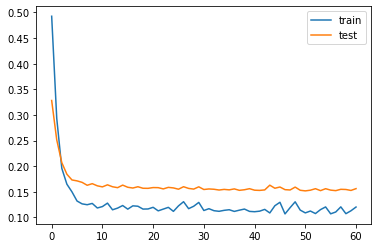

In [8]:
# design network
model = keras.models.Sequential([     
                                 keras.layers.RNN(LNSimpleRNNCell(50), return_sequences=True, input_shape=[train_X.shape[1], train_X.shape[2]]),     
                                 keras.layers.RNN(LNSimpleRNNCell(50), return_sequences=True),    
                                 keras.layers.TimeDistributed(keras.layers.Dense(1)) ])
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/100
6/6 - 4s - loss: 0.2395 - val_loss: 0.2269 - 4s/epoch - 749ms/step
Epoch 2/100
6/6 - 0s - loss: 0.1523 - val_loss: 0.1734 - 116ms/epoch - 19ms/step
Epoch 3/100
6/6 - 0s - loss: 0.1462 - val_loss: 0.1608 - 107ms/epoch - 18ms/step
Epoch 4/100
6/6 - 0s - loss: 0.1266 - val_loss: 0.1705 - 151ms/epoch - 25ms/step
Epoch 5/100
6/6 - 0s - loss: 0.1175 - val_loss: 0.1574 - 162ms/epoch - 27ms/step
Epoch 6/100
6/6 - 0s - loss: 0.1176 - val_loss: 0.1567 - 140ms/epoch - 23ms/step
Epoch 7/100
6/6 - 0s - loss: 0.1149 - val_loss: 0.1587 - 156ms/epoch - 26ms/step
Epoch 8/100
6/6 - 0s - loss: 0.1092 - val_loss: 0.1546 - 133ms/epoch - 22ms/step
Epoch 9/100
6/6 - 0s - loss: 0.1116 - val_loss: 0.1544 - 126ms/epoch - 21ms/step
Epoch 10/100
6/6 - 0s - loss: 0.1095 - val_loss: 0.1543 - 125ms/epoch - 21ms/step
Epoch 11/100
6/6 - 0s - loss: 0.1092 - val_loss: 0.1534 - 111ms/epoch - 19ms/step
Epoch 12/100
6/6 - 0s - loss: 0.1090 - val_loss: 0.1538 - 130ms/epoch - 22ms/step
Epoch 13/100
6/6 - 0s - los

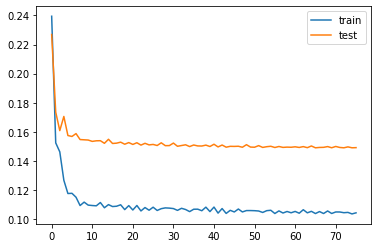

In [9]:
# design network
model = keras.models.Sequential([     
                                 keras.layers.RNN(LNSimpleRNNCell(50), return_sequences=True, input_shape=[train_X.shape[1], train_X.shape[2]]),
                                 keras.layers.LSTM(50, return_sequences=True),        
                                 keras.layers.TimeDistributed(keras.layers.Dense(1)) ])
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.layers import RNN

Epoch 1/1000
8/8 - 12s - loss: 0.1508 - val_loss: 0.1688 - 12s/epoch - 1s/step
Epoch 2/1000
8/8 - 0s - loss: 0.1023 - val_loss: 0.0710 - 435ms/epoch - 54ms/step
Epoch 3/1000
8/8 - 0s - loss: 0.0223 - val_loss: 0.0488 - 468ms/epoch - 59ms/step
Epoch 4/1000
8/8 - 0s - loss: 0.0374 - val_loss: 0.0403 - 443ms/epoch - 55ms/step
Epoch 5/1000
8/8 - 0s - loss: 0.0208 - val_loss: 0.0371 - 490ms/epoch - 61ms/step
Epoch 6/1000
8/8 - 0s - loss: 0.0206 - val_loss: 0.0344 - 472ms/epoch - 59ms/step
Epoch 7/1000
8/8 - 0s - loss: 0.0174 - val_loss: 0.0295 - 478ms/epoch - 60ms/step
Epoch 8/1000
8/8 - 0s - loss: 0.0128 - val_loss: 0.0258 - 457ms/epoch - 57ms/step
Epoch 9/1000
8/8 - 0s - loss: 0.0115 - val_loss: 0.0231 - 437ms/epoch - 55ms/step
Epoch 10/1000
8/8 - 0s - loss: 0.0102 - val_loss: 0.0226 - 482ms/epoch - 60ms/step
Epoch 11/1000
8/8 - 0s - loss: 0.0097 - val_loss: 0.0217 - 460ms/epoch - 57ms/step
Epoch 12/1000
8/8 - 0s - loss: 0.0091 - val_loss: 0.0206 - 484ms/epoch - 60ms/step
Epoch 13/1000
8/

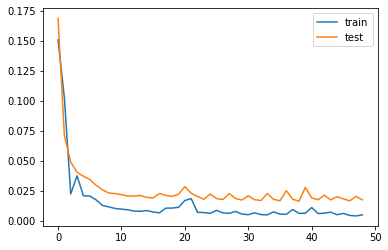

In [37]:
# design network
model = Sequential()
model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=True))
model.add(RNN(tfa.rnn.LayerNormLSTMCell(50), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=1000, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [15]:
class LNSimpleRNNCell(keras.layers.Layer):
       def __init__(self, units, activation="tanh", **kwargs):         
         super().__init__(**kwargs)         
         self.state_size = units         
         self.output_size = units         
         self.simple_rnn_cell = tfa.rnn.LayerNormLSTMCell(units)                     
       def call(self, inputs, states):         
         outputs, new_states = self.simple_rnn_cell(inputs, states)                
         return outputs

## Predictions 

In [38]:
# make a prediction using 2020 (not used for training or validation, and has different dynamics due to covid)
# adding back the data from 2020
Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = Moggio.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
#scaling and creating the new testing data
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 35) 365 (365,)
(365, 5, 7) (365,) (568, 5, 7) (568,)


In [39]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.387


#### Prediciton plots

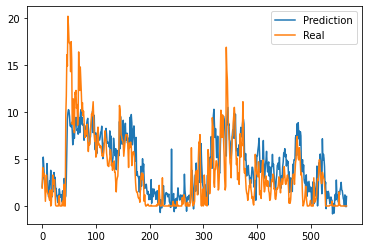

In [40]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

# Modeling with hyperparamenter search

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 2.8 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
def model_builder(hp):
  # design network
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model = Sequential()
  model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  for i in range(hp.Int('layers',1,3)):
   model.add(LSTM(units = hp_units, return_sequences=True))
  model.add(LSTM(units = hp_units, return_sequences=False))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
  return model

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial =3,
    directory = 'dir',
    project_name = 'namee')
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

Trial 10 Complete [00h 03m 25s]
val_loss: 0.08057895551125209

Best val_loss So Far: 0.052939437329769135
Total elapsed time: 00h 55m 57s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

### Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [ ]:
tuner.search(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])